# The Data Incubator: Challenge Pt. 3

## Challenge Description:
I am deeply interested in NLP and fakeness on the internet, so I propose a project dealing with the analysis of product reviews on consumer websites. I would like to see if there is any relationship between the sentiment score within a review and whether or not a review is likely to be fraudulent/paid. For simplicity's sake, I used the VADER sentiment scoring method across reviews in a Kaggle dataset, and figured out that not only are there slight negative correlations between the length of a review and negative sentiment, but that products with fewer reviews also have significantly higher positive and negative sentiment scores. This suggests (to me, based on some other subject matter knowledge) that product reviews might be 'seeded' with some influential reviews at the start and then average out to be more neutral over time.

Given more time (and a more robust dataset that included things like product categories etc.) I would want to use a different kind of scoring system for sentiment (likely a neural network-based system) or find particular entities within the text and see if there's any connection between naming a particular entity and a higher or lower score.

In [212]:
# imports
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load the data
# which comes from
# https://www.kaggle.com/abhinandan103/amazon-fine-food-review
df = pd.read_csv('Reviews.csv')

In [77]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'tokens',
       'com', 'neg', 'neu', 'pos', 'helpful'],
      dtype='object')

In [65]:
# tokeinze
df['tokens'] = df.apply(lambda row: tokenize.word_tokenize(str(row['Text'])), axis=1)

# use vader sentiment scoring for a simple sentiment metric
sid = SentimentIntensityAnalyzer()
df['com'] = df.apply(lambda row: sorted(sid.polarity_scores(row['tokens'][0]).items())[0][1], axis=1)
df['neg'] = df.apply(lambda row: sorted(sid.polarity_scores(row['tokens'][0]).items())[1][1], axis=1)
df['neu'] = df.apply(lambda row: sorted(sid.polarity_scores(row['tokens'][0]).items())[2][1], axis=1)
df['pos'] = df.apply(lambda row: sorted(sid.polarity_scores(row['tokens'][0]).items())[3][1], axis=1)

In [118]:
# make a 'helpfulness score', well, just because...
df['helpful'] = (df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'])
df['helpful'].fillna(0)
clear

0         1.0
1         0.0
2         1.0
3         1.0
4         0.0
5         0.0
6         0.0
7         0.0
8         1.0
9         0.0
10        1.0
11        1.0
12        1.0
13        1.0
14        0.8
15        0.8
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        1.0
         ... 
568424    1.0
568425    1.0
568426    1.0
568427    1.0
568428    1.0
568429    1.0
568430    0.0
568431    0.0
568432    0.0
568433    0.0
568434    0.0
568435    0.0
568436    1.0
568437    1.0
568438    1.0
568439    0.0
568440    1.0
568441    0.0
568442    0.0
568443    0.0
568444    1.0
568445    1.0
568446    0.0
568447    0.0
568448    0.0
568449    0.0
568450    0.0
568451    1.0
568452    1.0
568453    0.0
Name: helpful, Length: 568454, dtype: float64

In [120]:
# get the length of reviews
df['len'] = df.apply(lambda row: len(row['tokens']), axis=1)

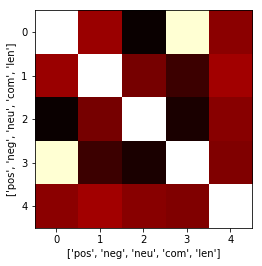

In [211]:
# correlation heatmap between sentiment and length of review
heat = df[['pos', 'neg', 'neu', 'com', 'len']]
data = heat.corr()
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.xlabel(['pos', 'neg', 'neu', 'com', 'len'])
plt.ylabel(['pos', 'neg', 'neu', 'com', 'len'])
plt.show()
# it seems overall that there are stronger correlations between
# negative sentiment and the length of a review than any of the
# other sentiment scores

In [146]:
stars = df.groupby('Score').mean()
stars[['com', 'neg', 'neu', 'pos']]

,com,neg,neu,pos
Score,,,,
1,0.003674,0.020223,0.561835,0.029636
2,0.008992,0.011724,0.534885,0.032349
3,0.016738,0.005441,0.586280,0.043762
4,0.029044,0.003744,0.596107,0.063381
5,0.035495,0.003949,0.587318,0.069013


In [185]:
topmask = df.groupby('ProductId').agg(['mean', 'count'])['Id']['count']


7.655121333728353

In [193]:
# get standard deviation for different bands of reviews
group = df.groupby('ProductId').agg(['mean', 'count'])
group.describe()
onestd = group[topmask < 27]
twostd = group[topmask >= 27]

In [228]:
# collect the means for sentiment scores and then get into list for plot
posabove = twostd['pos'].mean()['mean']
negabove = twostd['neg'].mean()['mean']
neuabove = twostd['neu'].mean()['mean']
#lenabove = twostd['len'].mean()['mean']

posbelow = onestd['pos'].mean()['mean']
negbelow = onestd['neg'].mean()['mean']
neubelow = onestd['neg'].mean()['mean']
#lenbelow = onestd['len'].mean()['mean']

below = [posbelow, negbelow, neubelow]
above = [posabove, negabove, neuabove]

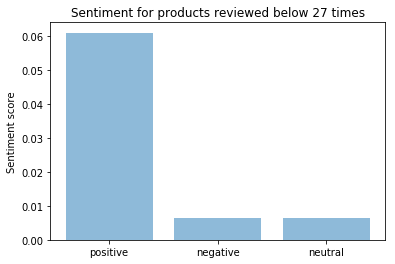

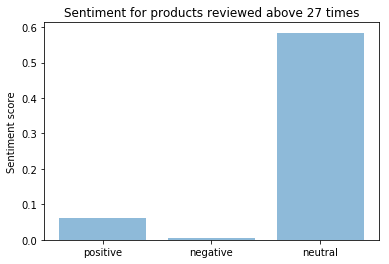

In [232]:
def plot_sent(plotlist, string):
    objects = ['positive', 'negative', 'neutral']
    y_pos = np.arange(len(plotlist))

    plt.bar(y_pos, plotlist, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Sentiment score')
    plt.title('Sentiment for products reviewed '+ string + ' 27 times')

    plt.show()
    
plot_sent(below, 'below')
plot_sent(above, 'above')

# it's interesting that items with fewer than 27 reviews have higher positive sentiment